In [ ]:
# default_exp desc.metrics.main

# Exploration of your data

> This module comprises some of the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

### Specifically in this module

> - Cyclomatic complexity (CYCLO)
> - Number of lines of code (NLOC)
> - Lack of Cohesion of Methods 5 (LCOM5)

### Limitations of Tools

> Languages this module plans to be able to process: Java, Javascript, Python, C++, C, Scala
##### Current Limitations
> - CYCLO/NLOC
> > - Can measure: Java
> > - Cannot measure: Python
> > - Can possibly measure: C, C++, Scala, Javascript
> - LCOM5
> > - Can measure: Java
> > - Cannot measure: Python, C++, Scala, Javascript
> > - Undefined: C

In [ ]:
# #hide
# from nbdev.showdoc import *

In [ ]:
# export
# Imports
import pandas as pd
from numpy import mean, std
from statistics import median
from scipy.stats import sem, t
import lizard
import matplotlib.pyplot as plt
from tree_sitter import Language, Parser, Node
#Decoding files
import chardet
from bs4 import UnicodeDammit


# TODO: Remove when mongo call is implemented
import os



from desc_metrics_parser_java import ParserJava

#Not implemented
#from desc_metrics_parser_cpp import ParserCPP
#from desc_metrics_parser_python import ParserPython

In [ ]:
#!git clone https://github.com/tree-sitter/tree-sitter-java
#!git clone https://github.com/tree-sitter/tree-sitter-cpp
#!git clone https://github.com/tree-sitter/tree-sitter-python

# Get_unicode & test

In [ ]:
# export
'''
Detects file encoding and returns unicode.
Inspired by http://reinvantveer.github.io/2017/05/19/unicode-dammit.html

:param file_path: file path of file
:returns: unicode string of the file
:raises ValueError: empty or invalud csv file
'''
def get_unicode(file_path):
    with open(file_path, 'rb') as f:
        detection = chardet.detect(f.read())
        
    enc = detection["encoding"]
    if detection["encoding"] == "ascii":
        with open(file_path, encoding="ascii") as f:
            data = f.read()
    elif detection["encoding"] == "ISO-8859-9":
        with open(file_path, encoding="utf-8") as f:
            enc = "utf-8"
            data = f.read()
    else:
        try:
            # Try to open as non unicode file
            with open(file_path, encoding=detection["encoding"]) as f:
                data = f.read()
        except Exception as e:
            raise ValueError(f"Cannot return dictionary from empty or invalid csv file {file_path} due to {e}")

    if not data:
        raise ValueError(f"Cannot return dictionary from empty or invalid csv file {file_path}")

    return UnicodeDammit(data).unicode_markup, enc

In [ ]:
# Setting up test data
file_path = "test_utf_8_file.txt"
with open(file_path, 'w', encoding="utf-8") as f:
    f.write("Hello, this is a test file")
# Calling function
text, encoding = get_unicode(file_path)
# Cleanup
os.remove(file_path)
# Displaying output
print(encoding)
print(text)

ascii
Hello, this is a test file


In [ ]:
'''
Loads files from a specified folder into a pandas dataframe

:param folder_path: path to folder
:returns: corpus_data dataframe
'''
def simulate_getting_dataframes_from_mongo(folder_path):
    corpus_data = {"system": [], "name": [], "ground_truth": [], "contents": [], "encoding": []}
    for file in os.listdir(folder_path):
        if not os.path.isdir(os.path.join(folder_path, file)) and file != ".DS_Store":
            corpus_data["system"].append(None)
            corpus_data["name"].append(file)
            corpus_data["ground_truth"].append("src")
            contents, enc = get_unicode(os.path.join(folder_path, file))
            corpus_data['encoding'].append(enc)
            corpus_data['contents'].append(contents)
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

# Add_mccabe_metrics & test

In [ ]:
# export
'''
Adds information about function length and cyclomatic complexity for classes to a dataframe

:param df: dataframe 
:param data_col: 
:param name_col:
:returns: dataframe with added columns
'''
def add_mccabe_metrics(df, data_col, name_col):
    num_funcs = []
    class_ccn = []
    avg_func_ccn = []
    avg_func_nloc = []
    for i in range(len(df)):
        file_num_funcs = []
        file_class_ccn = []
        file_avg_func_ccn = []
        file_avg_func_nloc = []
        metrics = lizard.analyze_file.analyze_source_code(df[name_col][i], df[data_col][i])
        class_dict = {}
        for func in metrics.function_list:
            class_name = '::'.join(func.name.split("::")[:-1])
            if class_name in class_dict:
                class_dict[class_name].append(func)
            else:
                class_dict[class_name] = [func]
        for class_key in class_dict:
            total_class_ccn = 0
            total_class_nloc = 0
            for func in class_dict[class_key]:
                total_class_ccn += func.cyclomatic_complexity
                total_class_nloc += func.length
            file_num_funcs.append(len(class_dict[class_key]))
            file_class_ccn.append(total_class_ccn)
            file_avg_func_ccn.append(total_class_ccn/len(class_dict[class_key]))
            file_avg_func_nloc.append(total_class_nloc/len(class_dict[class_key]))

        num_funcs.append(file_num_funcs)
        class_ccn.append(file_class_ccn)
        avg_func_ccn.append(file_avg_func_ccn)
        avg_func_nloc.append(file_avg_func_nloc)

    df["num_funcs"] = num_funcs
    df["class_ccn"] = class_ccn
    df["avg_func_ccn"] = avg_func_ccn
    df["avg_func_nloc"] = avg_func_nloc
    return df

In [ ]:
# Setting up test data
file_path = "test_java_file.java"
folder_path = "test_dir"
if not(folder_path):
    os.mkdir(folder_path)
with open(os.path.join(folder_path, file_path), 'w') as f:
    f.write("public int main() {}")
# Calling function
pd_dataframe = simulate_getting_dataframes_from_mongo(folder_path)
pd_dataframe = add_mccabe_metrics(pd_dataframe, "contents", "name")
# Cleanup
os.remove(os.path.join(folder_path,file_path))
os.rmdir(folder_path)
# Displaying output
pd.set_option('display.expand_frame_repr', False)
pd_dataframe.head()

,system,name,ground_truth,contents,encoding,num_funcs,class_ccn,avg_func_ccn,avg_func_nloc
0,None,test_java_file.java,src,public int main() {},ascii,[1],[1],[1.0],[1.0]


In [ ]:
'''
Creates a dictionary of tree-sitter parsers for select languages

:param path: None
:returns: dictionary with:
java, java language
cpp, cpp language
python, python language
'''
def create_parser_builds(path=None):
    """Creates a dictionary of tree-sitter parsers for select languages"""
    Language.build_library(
        # Store the library in the `build` directory
        'build/my-languages.so',

        # Include one or more languages
        [
            'tree-sitter-java',
            'tree-sitter-cpp',
            'tree-sitter-python'
        ]
    )

    JAVA_LANGUAGE = Language('build/my-languages.so', 'java')
    CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')
    PY_LANGUAGE = Language('build/my-languages.so', 'python')
    
    return {"java":JAVA_LANGUAGE, "cpp":CPP_LANGUAGE, "py":PY_LANGUAGE}

In [ ]:
'''
returns correct parser based on file extension
'''
def lcom5_parser(ext):
    if ext == "java":
        return ParserJava()
    if ext == "cpp":
        return ParserCPP()
    if ext == "py":
        return ParserPython()
    print(f"ERROR: No LCOM5 parser available for .{ext} extension files")

In [ ]:
#export
'''
Parses the syntax tree of code to calculate the LCOM5 of its classes

:param tree: syntax tree
:param extension: file extension type
:param file_bytes: list of bytes
:param name: not used
:returns: LCOM5 list
'''
def calculate_lcom5(tree, extension, file_bytes, name):
    parser = lcom5_parser(extension)
    if not parser:
        return ["Undefined"]

    root_node = tree.root_node
    class_nodes = parser.find_class_nodes(root_node)
    class_method_names = []
    class_field_names = []
    class_dfc = [] # Distinct field calls, as per the definition of LCOM5
    for node in enumerate(class_nodes):
        class_method_names.append(parser.find_method_names(node[1], file_bytes))
        class_field_names.append(parser.find_field_names(node[1], class_method_names[node[0]], file_bytes))
        class_dfc.append(parser.distinct_field_calls(node[1], class_field_names[node[0]], file_bytes))
    lcom5_list = []
    for j in range(len(class_nodes)):
        num_fields = len(class_field_names[j])
        num_meths = len(class_method_names[j])
        num_dac = class_dfc[j]
        numerator = num_dac - (num_meths*num_fields)
        denominator = num_fields - (num_meths*num_fields)
        if denominator == 0:
            lcom5_list.append("Undefined")
        else:
            lcom5_list.append(numerator/denominator)
    return lcom5_list

# Add_lcom5 & test

In [ ]:
#export
def add_lcom5(df, col):
    """Adds a column with the LCOM5 of each class of each file to a dataframe"""
    lang_builds = create_parser_builds()
    parser = Parser()
    class_lcom5 = []
    
    for i in range(len(df)):
        ext = df["name"][i].split('.')[-1]
        parser.set_language(lang_builds[ext])
        enc = df["encoding"][i]
        tree = parser.parse(bytes(df["contents"][i], df["encoding"][i]))
        class_lcom5.append(calculate_lcom5(tree, ext, bytes(df["contents"][i], df["encoding"][i]), df["name"][i]))
    df["class_lcom5"] = class_lcom5
    
    return df

In [ ]:
# Setting up test data
file_path = "test_java_file.java"
folder_path = "test_data/test_dir"
if(not folder_path):
    os.mkdir(folder_path)
with open(os.path.join(folder_path, file_path), 'w') as f:
    f.write("class SomeClass {int var, i, able; public int main() {return 0;} public void helper() {return i;}}")
# Calling function
pd_dataframe = simulate_getting_dataframes_from_mongo(folder_path)
pd_dataframe = add_lcom5(pd_dataframe, "contents")
# Cleanup
os.remove(os.path.join(folder_path,file_path))
os.rmdir(folder_path)
# Displaying output
pd.set_option('display.expand_frame_repr', False)
pd_dataframe.head()

,system,name,ground_truth,contents,encoding,class_lcom5
0,None,test_java_file.java,src,"class SomeClass {int var, i, able; public int ...",ascii,[1.6666666666666667]


# Flatten_lol & test

In [ ]:
#export
'''
Takes in a list of lists and flattens it, returning a list of each entry

:param list_list: list of lists to flatten
:returns: flattened list
'''
def flatten_lol(list_list):
    flattened_list = []
    for sublist in list_list:
        for entry in sublist:
            flattened_list.append(entry)
    return flattened_list

In [ ]:
# Setting up test data
list_of_lists = [[1, 2, 3], [5, 6, 7], ["apple", "pear", "banana"]]
# Calling function
flattened = flatten_lol(list_of_lists)
# Displaying outputs
assert(str(flattened) == "[1, 2, 3, 5, 6, 7, 'apple', 'pear', 'banana']")

[1, 2, 3, 5, 6, 7, 'apple', 'pear', 'banana']


# Display_numeric_col_stats & test

In [ ]:
# export
def display_numeric_col_stats(col, conf = 0.95, sig_figs = 4, clean=True, verbose_clean=False):
    """Computes statistical metrics about the entries in a dataframe column or list"""
    previous_length = len(col)
    numeric_types = [int, float, complex]
    if clean: col = [x for x in col if type(x) in numeric_types]
    if verbose_clean: print(f"Cleaning removed {previous_length - len(col)} non-numeric entries")

    if len(col) < 1:
        print("Error, data must contain at least one valid entry to display statistics")
        return

    print("Min =", round(min(col), sig_figs))
    print("Max =", round(max(col), sig_figs))
    print("Average =", round(mean(col), sig_figs))
    print("Median =", round(median(col), sig_figs))
    print("Standard Deviation =", round(std(col), sig_figs))
    
    n = len(col)
    m = mean(col)
    std_err = sem(col)
    h = std_err * t.ppf((1 + conf) / 2, n - 1)

    start = m - h
    end = m + h
    print(f"{conf} of data points fall between {round(start, sig_figs)} and {round(end, sig_figs)}")

In [ ]:
# Setting up test data
data = [[1, 2, 3], [3, 3, 4, 5], ["apple" "banana"]]
flat_data = flatten_lol(data)
# Calling function
display_numeric_col_stats(flat_data)
"""Note: the function ignores not-numeric entries, so apple, 
pear and banana do not create issues"""

Min = 1
Max = 5
Average = 3.0
Median = 3
Standard Deviation = 1.1952
0.95 of data points fall between 1.806 and 4.194


'Note: the function ignores not-numeric entries, so apple, \npear and banana do not create issues'

# Display_numeric_col_hist & test

In [ ]:
#export
'''
Displays a histogram with a customized number of bins for the data in a specified dataframe column or list

:param col: df column or list to plot
:param col_name: name of col
:param num_bins: number of bins
:param clean: only look at ints, floats, or complex in col
:param verbose_clean: displays non-numeric entries removed
'''
def display_numeric_col_hist(col, col_name="Metric", num_bins=20, clean=True, verbose_clean=False):
    previous_length = len(col)
    numeric_types = [int, float, complex]
    if clean: col = [x for x in col if type(x) in numeric_types]
    if verbose_clean: print(f"Cleaning removed {previous_length - len(col)} non-numeric entries")

    if len(col) < 1:
        print("Error, data must contain at least one valid entry to display histogram")
        return    

    rng = max(col) - min(col)
    num = len(col)
    stnd_dev = std(col)

    plt.hist(col, num_bins, color="blue", alpha=0.5, edgecolor="black", linewidth=1.0)
    plt.title(col_name + " Histogram")
    plt.ylabel("Value  Range  Occurrences")
    plt.xlabel(col_name)
    plt.show()

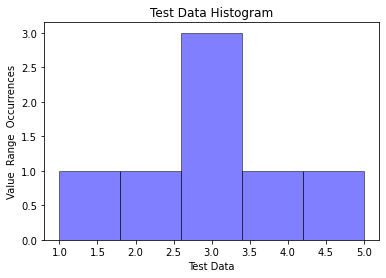

'Note: the function ignores not-numeric entries, so apple, \npear and banana do not create issues'

In [ ]:
# Setting up test data
data = [[1, 2, 3], [3, 3, 4, 5], ["apple" "banana"]]
flat_data = flatten_lol(data)
# Calling function
display_numeric_col_hist(flat_data, "Test Data", num_bins=5)
"""Note: the function ignores not-numeric entries, so apple, 
pear and banana do not create issues"""